# Spaceship Titanic dataset (Kaggle)

The models implemented here use the following predictors:

- `Age`: The age of the passenger. [`numeric`]
- `HomePlanet`: The planet the passenger departed from, typically their planet of permanent residence. [`categorical`]
- `CryoSleep`: Indicates whether the passenger was put into suspended animation. Passengers in cryosleep are confined to their cabins. [`integer`]
- `Destination`: The planet the passenger will be debarking to. [`categorical`]
- `VIP`: Whether the passenger has paid for special VIP service during the voyage. [`integer`]
- `group_size_bin`: The size of the group the passenger is travellin with (category: "g1", "g2", "g3", "g4more", for 1, 2, 3 or 4-or-more, respectively). [`categorical`]
- `deck`: The deck information from **Cabin** column. [`categorical`]
- `side`: The side information from **Cabin** column. [`integer`]
- `amenities_sum_bin`: The discrete intervals of **amenities_sum** column, where *low*=0, *medium*=(0,1450], *high*=(1450,np.inf]. The value "1450" is the 3rd quartile of **amenities_sum**. [`categorical`]

\
Label:
- `Transported`: Whether the passenger was transported to another dimension. [`binary`]

\
The best model is a **SVM Classifier** with **polynomial Kernel** (but it is still very similar to the results of the other models).

# Load libraries

In [119]:
from pathlib import Path
import sys
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.model_selection import GridSearchCV

np.random.seed(123)

# Python version
print(f"sys: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborns {sns.__version__}")

sys: 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
numpy: 1.24.2
scipy: 1.10.1
pandas: 1.5.3
matplotlib: 3.7.1
seaborns 0.12.2


# Load data

In [120]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)
print(f"Shape: {X_y_train.shape}")

Shape: (6954, 14)


In [121]:
print(X_y_train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [122]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6789 non-null   object 
 2   CryoSleep     6782 non-null   object 
 3   Cabin         6795 non-null   object 
 4   Destination   6805 non-null   object 
 5   Age           6809 non-null   float64
 6   VIP           6800 non-null   object 
 7   RoomService   6801 non-null   float64
 8   FoodCourt     6796 non-null   float64
 9   ShoppingMall  6788 non-null   float64
 10  Spa           6808 non-null   float64
 11  VRDeck        6809 non-null   float64
 12  Name          6786 non-null   object 
 13  Transported   6954 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 713.2+ KB


In [123]:
X_y_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,7527_01,Earth,False,F/1561/P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley,True
1,7083_01,Europa,True,C/259/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus,True
2,2755_01,Europa,True,B/85/P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy,True
3,4127_01,Europa,NaN,B/130/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle,True
4,7972_02,Europa,False,B/260/P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried,False


In [124]:
print(f"shape X_y_train: {X_y_train.shape}")

shape X_y_train: (6954, 14)


In [125]:
# NOTE: "drop()" create a copy of the data original dataset
X_train = X_y_train.drop(["Transported"], axis=1)
y_train = X_y_train.loc[:, "Transported"].copy()

print(f"shape X_train: {X_train.shape}")
print(f"shape y_train: {y_train.shape}")

shape X_train: (6954, 13)
shape y_train: (6954,)


# Define pipelines

In [126]:
# Define columns to convert
c_cat = ["HomePlanet", "Cabin", "Destination"]
c_str = ["PassengerId", "Name"]
# c_bool = ["CryoSleep", "VIP"]

In [127]:
# Function to convert data type & add column
def convert_df(df_in: pd.DataFrame,
               col_cat: list[str],
               col_str: list[str],
               # col_bool: list[str]
 ) -> pd.DataFrame:
    """Converts the specified columns to categorical, string or bool types."""

    df_out = df_in.copy()

    for column in col_cat:
        df_out[column] = df_out[column].astype("category")
    
    for column in col_str:
        df_out[column] = df_out[column].astype("string")

    # NOTE: EXCLUDED because "SimpleImputer" does not support data with dtype bool
    # for column in col_bool:
    #     df_out[column] = df_out[column].astype("bool")

    return df_out

## CombinedAttributesAdder

Define a class that transforms and select various features.

In [128]:
# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid '*args' or "**kargs" in "__init__"
    def __init__(self):
        pass

    # fit is needed later for the pipilene
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert column type
        X = convert_df(
            df_in=X,
            col_cat=c_cat,
            col_str=c_str,
            #col_bool=c_bool,
        )

        # Add "group" and "group_n"
        X[["group", "group_n"]] = X.PassengerId.str.split("_", expand=True)

        # Add "group_size" (a column with the size of the group)
        count_group_size = (
             X
             .value_counts(["group"], sort=False)
             .rename("group_size")
             .reset_index()
        )
        X = pd.merge(X, count_group_size, how="left", on="group")

        # Add "group_size_bin"
        X.loc[:, "group_size_bin"] = np.nan
        X.loc[X.group_size == 1, "group_size_bin"] = "g1"
        X.loc[X.group_size == 2, "group_size_bin"] = "g2"
        X.loc[X.group_size == 3, "group_size_bin"] = "g3"
        X.loc[X.group_size >= 4, "group_size_bin"] = "g4more"
        X["group_size_bin"] = X["group_size_bin"].astype("category")

        # Add "deck", "num" and "side"
        X[["deck", "num", "side"]] = X.Cabin.str.split("/", expand=True)
        X["deck"] = X["deck"].astype("category")
        X["num"] = X["num"].astype("string")
        X["side"] = X["side"].astype("category")
        
        # Add "amenities_sum"
        X["amenities_sum"] = X[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

        # Add "amenities_sum_bin"
        bins = [-np.inf, 0, 1450, np.inf]
        names = ["low", "medium", "high"]
        X.loc[:, "amenities_sum_bin"] = pd.cut(X.amenities_sum, bins=bins, labels=names)

        # Drop unused columns
        cols_to_drop = ['PassengerId', 'Cabin', 'RoomService', 'FoodCourt',
                        'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'group',
                        'group_n', 'group_size', 'num', 'amenities_sum']
        X.drop(columns=cols_to_drop, inplace=True)

        return X

In [129]:
p1 = CombinedAttributesAdder()
X_train_tmp = p1.fit_transform(X_train)
X_train_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 0 to 6953
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   HomePlanet         6789 non-null   category
 1   CryoSleep          6782 non-null   object  
 2   Destination        6805 non-null   category
 3   Age                6809 non-null   float64 
 4   VIP                6800 non-null   object  
 5   group_size_bin     6954 non-null   category
 6   deck               6795 non-null   category
 7   side               6795 non-null   category
 8   amenities_sum_bin  6954 non-null   category
dtypes: category(6), float64(1), object(2)
memory usage: 259.1+ KB


In [130]:
pd.isna(X_train_tmp).sum(axis=0)

HomePlanet           165
CryoSleep            172
Destination          149
Age                  145
VIP                  154
group_size_bin         0
deck                 159
side                 159
amenities_sum_bin      0
dtype: int64

## num_pipeline

It preprocesses the numerical attributes with `SimpleImputer()` and `StandardScaler()`.

In [131]:
print(X_train_tmp.describe())

               Age
count  6809.000000
mean     28.767367
std      14.479764
min       0.000000
25%      19.000000
50%      27.000000
75%      37.000000
max      79.000000


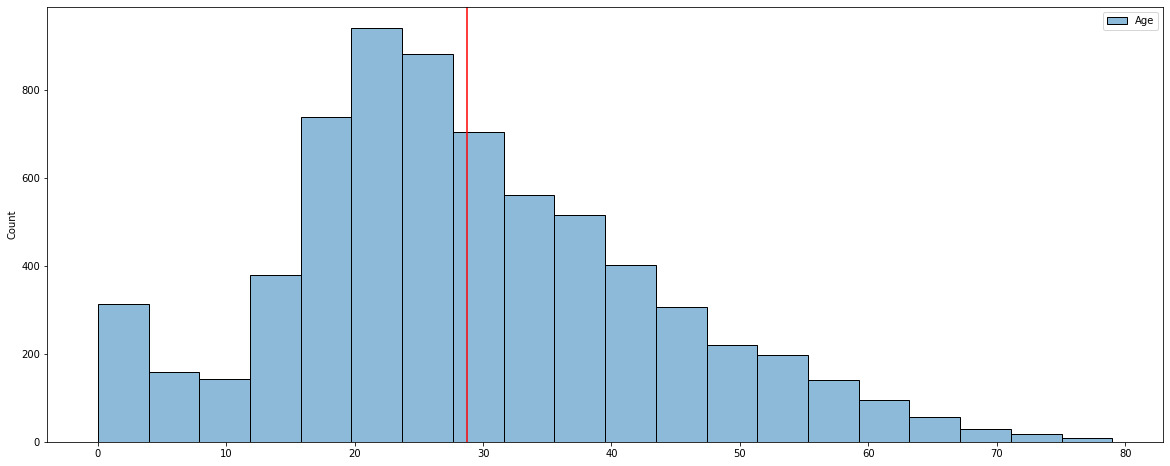

In [132]:
plt.figure(figsize=(20, 8))
sns.histplot(X_train_tmp.loc[:, ["Age"]], bins=20)
plt.axvline(X_train_tmp.Age.mean(), color='red')
plt.show()

In [133]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with mean
    ('imputer', SimpleImputer(strategy='mean')),
    # standardize the variables: z = (x - mean) / SD
    ('std_scaler', StandardScaler())])

In [134]:
age = num_pipeline.fit_transform(X_train_tmp.loc[:, ["Age"]])
print(f"Shape: {age.shape}")
print(f"number of NaN: {np.sum(np.isnan(age))}")

Shape: (6954, 1)
number of NaN: 0


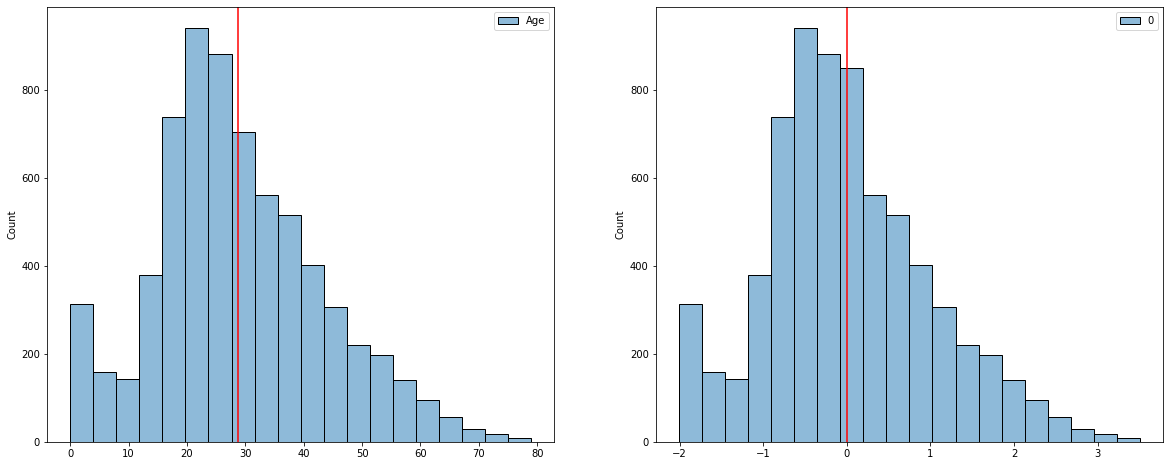

In [135]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sns.histplot(X_train_tmp.loc[:, ["Age"]], bins=20)
plt.axvline(X_train_tmp.Age.mean(), color='red')
plt.subplot(122)
sns.histplot(age, bins=20)
plt.axvline(age.mean(), color='red')
plt.show()

## cat_pipeline

It preprocesses the categorical attributed with `SimpleImputer()` and `OneHotEncoder()`.

In [136]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder(drop='if_binary'))])

In [137]:
pd.isna(X_train_tmp).sum(axis=0)

HomePlanet           165
CryoSleep            172
Destination          149
Age                  145
VIP                  154
group_size_bin         0
deck                 159
side                 159
amenities_sum_bin      0
dtype: int64

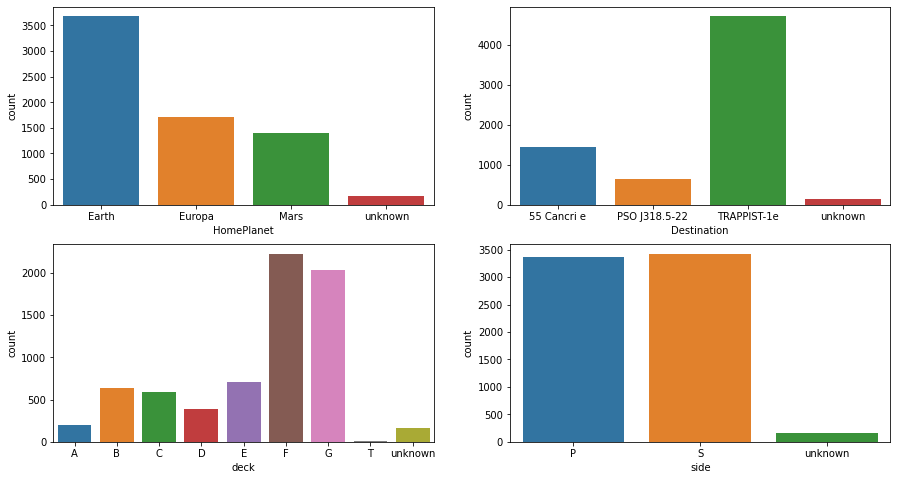

In [138]:
cat_with_nan = ["HomePlanet", "Destination", "deck", "side"]

plt.figure(figsize=(15 ,8))
for i, feature in enumerate(cat_with_nan):
    plot_me = (
        X_train_tmp.loc[:, feature]
       .value_counts(dropna=False)
       .rename("count")
       .reset_index()
       .rename(columns={"index":feature})
    )
    plot_me[plot_me.columns[0]] = (
        plot_me[plot_me.columns[0]]
        .cat
        .add_categories("unknown")
        .fillna("unknown")
    )
    plt.subplot(2, 2, i+1)
    sns.barplot(data=plot_me, x=feature, y="count")
plt.show()

In [139]:
cat_test = cat_pipeline.fit_transform(X_train_tmp.loc[:, ["HomePlanet"]])
print(f"Shape: {X_train_tmp.HomePlanet.shape}")
print(f"Shape: {cat_test.shape}")

Shape: (6954,)
Shape: (6954, 3)


## Combine pipelines

In [140]:
list_num_attribs = ["Age"]
list_cat_attribs = ["HomePlanet", "CryoSleep", "Destination", "VIP",
                    "group_size_bin", "deck", "side", "amenities_sum_bin"]

In [141]:
# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, list_num_attribs),
    # apply "cat_pipeline" to categorical columns
    ('cat_m', cat_pipeline, list_cat_attribs)
    ])

In [142]:
full_pipeline = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

In [143]:
# print(full_pipeline.get_params().keys())
# print(full_pipeline.get_params().items())
print(full_pipeline.get_params())


{'memory': None, 'steps': [('attribs_adder', CombinedAttributesAdder()), ('cols_transformer', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('cat_m',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'group_size_bin', 'deck', 'side',
                                  'amenities_sum_bin'])]))], 'verbose': False, 'attribs_adder': CombinedAttributesAd

In [144]:
for i in full_pipeline.get_params().keys():
    print(i)

memory
steps
verbose
attribs_adder
cols_transformer
cols_transformer__n_jobs
cols_transformer__remainder
cols_transformer__sparse_threshold
cols_transformer__transformer_weights
cols_transformer__transformers
cols_transformer__verbose
cols_transformer__verbose_feature_names_out
cols_transformer__num
cols_transformer__cat_m
cols_transformer__num__memory
cols_transformer__num__steps
cols_transformer__num__verbose
cols_transformer__num__imputer
cols_transformer__num__std_scaler
cols_transformer__num__imputer__add_indicator
cols_transformer__num__imputer__copy
cols_transformer__num__imputer__fill_value
cols_transformer__num__imputer__keep_empty_features
cols_transformer__num__imputer__missing_values
cols_transformer__num__imputer__strategy
cols_transformer__num__imputer__verbose
cols_transformer__num__std_scaler__copy
cols_transformer__num__std_scaler__with_mean
cols_transformer__num__std_scaler__with_std
cols_transformer__cat_m__memory
cols_transformer__cat_m__steps
cols_transformer__cat_

# Baseline model (log regression)

In [145]:
clf_baseline = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Logistic regression (with default paramenters)
    ("log_reg", LogisticRegression(random_state=123))])

In [146]:
clf_baseline.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age']),
                                                                  ('cat_m',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side',
                                                                    'amenities_sum_bin'])]))])),
                ('log_reg', LogisticRegression(random_state=123))])

In [147]:
y_pred_baseline = clf_baseline.predict(X_train)

## Define functions

In [148]:
def add_metrics(dictionary, y, y_pred, mod_name):
    # dictionary: a dictionary to which the metrics are added

    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    dictionary[mod_name] = {
        "accuracy": np.round(acc, 3),
        "confusion_matrix": cm,
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "f1_score": np.round(f1, 3)
    }

    return dictionary


def print_metrics(m):
    print(f"Accuracy is {m['accuracy']:.2f}.")
    print(f"When the model claims a passenger was transported to another dimension, it is correct {m['precision']*100:.2f} % of the time (precision).")
    print(f"The model detects {m['recall']*100:.2f} % of the passengers that were transported to another dimension (recall).")
    print(f"The F1 score is {m['f1_score']*100:.2f}.")


def display_cm(cm):
    # cm: a confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def compare_models(models):
    mods_table = pd.DataFrame.from_dict(models)
    return mods_table.loc[["accuracy", "precision", "recall", "f1_score"],:]

## Metrics

In [149]:
models_score = dict()
models_score = add_metrics(models_score, y_train, y_pred_baseline, "baseline")

In [150]:
print_metrics(models_score["baseline"])

Accuracy is 0.74.
When the model claims a passenger was transported to another dimension, it is correct 77.80 % of the time (precision).
The model detects 66.50 % of the passengers that were transported to another dimension (recall).
The F1 score is 71.70.


In [151]:
models_score["baseline"]["confusion_matrix"]

array([[2802,  662],
       [1168, 2322]], dtype=int64)

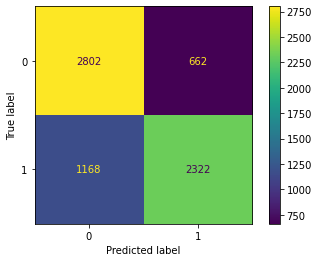

In [152]:
display_cm(models_score["baseline"]["confusion_matrix"])

# SGD Classifer

This results should be similar to the logistic regression model.

In [153]:
clf_sgd = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # LSGD Classifier (with default paramenters)
    ("sgd", SGDClassifier())])

In [154]:
clf_sgd.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age']),
                                                                  ('cat_m',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side',
                                                                    'amenities_sum_bin'])]))])),
                ('sgd', SGDClassifier())])

In [155]:
y_pred_sgd = clf_sgd.predict(X_train)

In [156]:
models_score = add_metrics(models_score, y_train, y_pred_sgd, "sgd")

In [157]:
print_metrics(models_score["sgd"])

Accuracy is 0.73.
When the model claims a passenger was transported to another dimension, it is correct 78.40 % of the time (precision).
The model detects 64.80 % of the passengers that were transported to another dimension (recall).
The F1 score is 71.00.


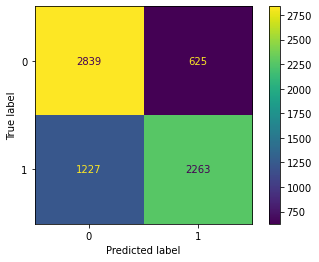

In [158]:
display_cm(models_score["sgd"]["confusion_matrix"])

# SVM

In [159]:
clf_svm = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # SVM Classifier
    ("SVM", LinearSVC(C=1, loss="hinge"))]) # dual=False

In [160]:
clf_svm.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age']),
                                                                  ('cat_m',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side',
                                                                    'amenities_sum_bin'])]))])),
                ('SVM', LinearSVC(C=1, loss='hinge'))])

In [161]:
y_pred_svm = clf_svm.predict(X_train)

In [162]:
models_score = add_metrics(models_score, y_train, y_pred_svm, "svm")

In [163]:
print_metrics(models_score["svm"])

Accuracy is 0.73.
When the model claims a passenger was transported to another dimension, it is correct 78.40 % of the time (precision).
The model detects 64.80 % of the passengers that were transported to another dimension (recall).
The F1 score is 71.00.


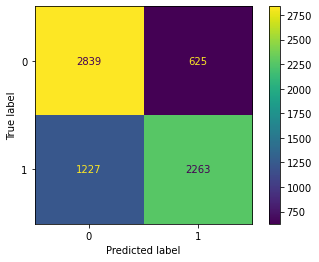

In [164]:
display_cm(models_score["svm"]["confusion_matrix"])

# SVM - Poly kernel

In [165]:
clf_svm_pk = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # SVM Classifier
    ("SVM", SVC(kernel="poly", degree=3))])

In [166]:
clf_svm_pk.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age']),
                                                                  ('cat_m',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side',
                                                                    'amenities_sum_bin'])]))])),
                ('SVM', SVC(kernel='poly'))])

In [167]:
y_pred_svm_pk = clf_svm_pk.predict(X_train)

In [168]:
models_score = add_metrics(models_score, y_train, y_pred_svm_pk, "svm_pk")

In [169]:
print_metrics(models_score["svm_pk"])

Accuracy is 0.75.
When the model claims a passenger was transported to another dimension, it is correct 79.80 % of the time (precision).
The model detects 67.40 % of the passengers that were transported to another dimension (recall).
The F1 score is 73.10.


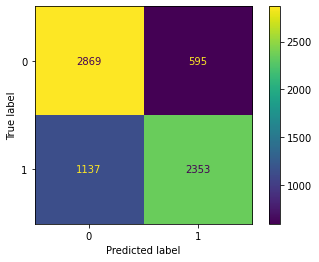

In [170]:
display_cm(models_score["svm_pk"]["confusion_matrix"])

# Compare models

In [171]:
compare_models(models_score)

,baseline,sgd,svm,svm_pk
accuracy,0.737,0.734,0.734,0.751
precision,0.778,0.784,0.784,0.798
recall,0.665,0.648,0.648,0.674
f1_score,0.717,0.71,0.71,0.731


# Test score

In [172]:
# Load test dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_test.csv"
X_y_test = load_ds(dataset_path, filename)
print(f"Shape: {X_y_test.shape}")

Shape: (1739, 14)


In [173]:
# NOTE: "drop()" create a copy of the data original dataset
X_test = X_y_test.drop(["Transported"], axis=1)
y_test = X_y_test.loc[:, "Transported"].copy()

print(f"shape X_train: {X_test.shape}")
print(f"shape y_train: {y_test.shape}")

shape X_train: (1739, 13)
shape y_train: (1739,)


In [174]:
y_test_pred = clf_svm_pk.predict(X_test)

In [175]:
test_score = dict()
test_score = add_metrics(test_score, y_test, y_test_pred, "svm_pk")

In [176]:
print_metrics(test_score["svm_pk"])

Accuracy is 0.77.
When the model claims a passenger was transported to another dimension, it is correct 81.40 % of the time (precision).
The model detects 71.30 % of the passengers that were transported to another dimension (recall).
The F1 score is 76.00.


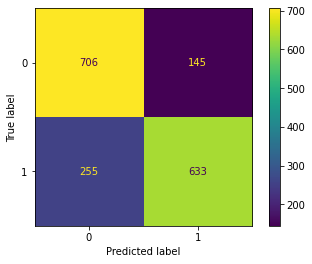

In [177]:
display_cm(test_score["svm_pk"]["confusion_matrix"])